<a href="https://colab.research.google.com/github/adhvaitaganesh/HLCV-Homework/blob/main/Final%20Project/code/birdSpotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an altered version of the notebook which was originally this: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-sqhj4_w4
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-sqhj4_w4
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263902 sha256=10d9d43cacf4c9fa79092c9d592aa515950798224aa3ce70134506e27e03e600
  Stored in directory: /tmp/pip-ephem-wheel-cache-50nsfpwy/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for nabirds data

Let's write a dataset for the nabirds dataset. It's owned by the Cornell lab of Ornithology. Please read the terms of usage: https://dl.allaboutbirds.org/merlin---computer-vision--terms-of-use?submissionGuid=54dd747f-72fe-4fb5-a8d3-5b9a545b35d4

First, let's download and extract the data, present in a tar file at https://www.dropbox.com/s/xv5dctllnse9tkw/nabirds.tar.gz


Important: Replace the file- nabirds.py in the dataset to the corrected version that we have on github

In [ ]:
%%shell

# download the nabirds dataset
wget https://www.dropbox.com/s/xv5dctllnse9tkw/nabirds.tar.gz
# extract it in the current folder
tar xf nabirds.tar.gz


--2021-08-02 05:37:48--  https://www.dropbox.com/s/xv5dctllnse9tkw/nabirds.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xv5dctllnse9tkw/nabirds.tar.gz [following]
--2021-08-02 05:37:48--  https://www.dropbox.com/s/raw/xv5dctllnse9tkw/nabirds.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6fff78c051f8cf0824062c7600.dl.dropboxusercontent.com/cd/0/inline/BTc7XweUHw-inki9f_uRAuPFdhEpidet977-rUisxBfEYhShflTJtaWNSrRj7aH1zMwB68VXw0X00BqLNTb-JdrJNZn7vy_y3G9hUK7m3W0yUGEXA7m-OAobOfxSgEEYfJe6pxAMauTVXbEvBsPy-AIk/file# [following]
--2021-08-02 05:37:48--  https://uc6fff78c051f8cf0824062c7600.dl.dropboxusercontent.com/cd/0/inline/BTc7XweUHw-inki9f_uRAuPFdhEpidet977-rUisxBfEYhShflTJtaWNSrRj7aH1zMwB68VXw0X00BqLNTb-

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from nabirds import nabirds

class nabirdsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        

        self.imgs = nabirds.load_image_paths(self.root, path_prefix= 'images')
        self.bboxes = nabirds.load_bounding_box_annotations(self.root)
        self.img_sizes = nabirds.load_image_sizes(self.root)
        id = 0
        self.img_id = {}
        for keys in list(self.imgs) :
          self.img_id[keys] = id
          id += 1



    def __getitem__(self, idx):
        # load images
        if isinstance(idx, int):
          for keys in self.img_id :
            if idx == self.img_id[keys] :
              idx = keys

        img_path = os.path.join(self.root, self.imgs[idx])
        
        img = Image.open(img_path).convert("RGB")
        
        boxes = list(self.bboxes[idx])
        boxes = torch.as_tensor((boxes,) ,dtype=torch.float32,)
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        num_objs = 1

        #boxes = torch.as_tensor((boxes,) ,dtype=torch.float32,)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        

        image_id = torch.tensor((self.img_id[idx],))
        area = (boxes[ :,3] - boxes[ :,1]) * (boxes[:,2] - boxes[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def get_height_and_width(self, idx) :
      height, width = img_sizes[idx]
      return height, width


    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = nabirdsDataset('/content/nabirds')
dataset['0001afd4-99a1-4a67-b940-d419413e23b3']

(<PIL.Image.Image image mode=RGB size=1024x680 at 0x7F093597D810>,
 {'area': tensor([110208.]),
  'boxes': tensor([[307., 179., 799., 403.]]),
  'image_id': tensor([3]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_spotter_model(num_classes):
    # load a detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 32789, done.
remote: Counting objects: 100% (5332/5332), done.
remote: Compressing objects: 100% (1152/1152), done.
remote: Total 32789 (delta 4257), reused 5097 (delta 4076), pack-reused 27457
Receiving objects: 100% (32789/32789), 39.28 MiB | 31.57 MiB/s, done.
Resolving deltas: 100% (24873/24873), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torchvision.transforms as TT


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = nabirdsDataset('/content/nabirds/', get_transform(train=True))
#dataset_for_test = nabirdsDataset('/content/nabirds/', get_transform(train=False))

# split the dataset in train and test set

train_indices, test_indices = nabirds.load_train_test_split('/content/nabirds/')
dataset_train = torch.utils.data.Subset(dataset, train_indices)
dataset_test = torch.utils.data.Subset(dataset, test_indices)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_spotter_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=1e-3 , weight_decay=0.01)
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=200)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #giving errors as img_id is not defined in the dataset. So find a way to convert id originally a string to a tensor
    #evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [    0/23929]  eta: 5:00:58  lr: 0.000002  loss: 1.2835 (1.2835)  loss_classifier: 1.1522 (1.1522)  loss_box_reg: 0.1024 (0.1024)  loss_objectness: 0.0087 (0.0087)  loss_rpn_box_reg: 0.0202 (0.0202)  time: 0.7547  data: 0.1708  max mem: 721
Epoch: [0]  [  200/23929]  eta: 0:51:14  lr: 0.000202  loss: 0.2126 (0.5354)  loss_classifier: 0.1159 (0.3901)  loss_box_reg: 0.0873 (0.1362)  loss_objectness: 0.0007 (0.0033)  loss_rpn_box_reg: 0.0025 (0.0059)  time: 0.1260  data: 0.0049  max mem: 758
Epoch: [0]  [  400/23929]  eta: 0:50:12  lr: 0.000402  loss: 0.1125 (0.3391)  loss_classifier: 0.0501 (0.2301)  loss_box_reg: 0.0540 (0.1007)  loss_objectness: 0.0007 (0.0032)  loss_rpn_box_reg: 0.0019 (0.0051)  time: 0.1198  data: 0.0048  max mem: 759
Epoch: [0]  [  600/23929]  eta: 0:49:17  lr: 0.000601  loss: 0.0911 (0.2639)  loss_classifier: 0.0354 (0.1676)  loss_box_reg: 0.0435 (0.0880)  loss_objectness: 0.0014 (0.0035)  loss_rpn_box_reg: 0.0018 (0.0048)  time: 0.1260  data: 0.0050  m

KeyError: ignored

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
torch.save( {
    "epoch" : epoch, 
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict()
}, 'checkptOneEpoch.pth' )
checkpoint = torch.load('checkptOneEpoch.pth')
model= get_spotter_model(2)
model.load_state_dict(checkpoint['model_state_dict']) #map_location = 'cpu' if youre loading on cpu
evaluate(model, data_loader_test, device=device) #still error in evaluation


torch.Size([4, 4])


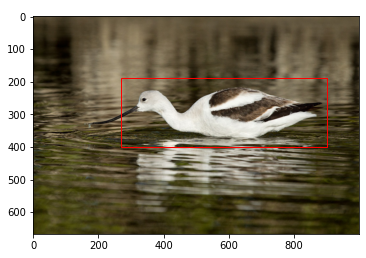

In [ ]:
#evaluate(model, dataset_train, device = device)
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
trans = torchvision.transforms.ToTensor()
aaa1 = Image.open('fff.jpg').convert("RGB") #upload this image
aaa = trans(aaa1)
aaa = torch.unsqueeze(aaa, dim=0)
out = model(aaa)
print(out[0]["boxes"].size())
#the predictor gives "boxes" of shape [N,4], in descending order of their scores (always), so 0th box is the best one
box = out[0]['boxes'][0]

def ImageWithBox(img, bbox, title = ' '):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.imshow(img)
  plt.text(0, -5, title)
  top_left = (bbox[0], bbox[1])
  width = bbox[2] - bbox[0]
  height = bbox[3] - bbox[1] 
  bbox = patches.Rectangle(top_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(bbox)
  plt.show()
ImageWithBox(aaa1, bbox = box)

This is an altered version of the notebook which was originally this: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial